In [1]:
import os
import itertools
import math

import sklearn.model_selection
import random
import torch
import torchvision

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(0)
random.seed(0)
SKLEARN_RANDOM_SEED = 0

MAX_BYTE = 255
NUM_EPOCHS = 200
BATCH_SIZE = 16
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Extract and organize data

In [3]:
quality_ratings = ["Pasul", "A", "AA", "Muvhar"]
IMG_HEIGHT = 323
COLLAGE_COLS = 5

img_shapes = [(3,), tuple(IMG_HEIGHT*i+1 for i in [1,2,3]), (1616,)]
example_collage = torchvision.io.read_image(os.path.join("Pasul", os.listdir("Pasul")[1]))
vertical_dividers = [col for col in range(img_shapes[2][0]) if (example_collage[:,:,col] == torch.full((3, img_shapes[1][-1]), 255)).all()]
horizontal_dividers = [row for row in range(img_shapes[1][-1]) if (example_collage[:,row,:] == torch.full((3, img_shapes[2][0]), 255)).all()]

class Fruit:
    def __init__(self, serial_num, collage, camera, rating):
        self.serial_num = serial_num
        self.images = self._imgs_from_collage(collage)
        self.camera = camera
        self.quality_rating = rating

    @staticmethod
    def _imgs_from_collage(collage):
        num_img_rows = collage.shape[1] // IMG_HEIGHT
        imgs = torch.stack([
            Fruit._img_from_collage(collage, img_row, img_col)
            for img_row, img_col in itertools.product(range(num_img_rows), range(COLLAGE_COLS))
            if not (
                Fruit._img_from_collage(collage, img_row, img_col) == torch.zeros_like(Fruit._img_from_collage(collage, img_row, img_col))
            ).all()
        ])
        return imgs

    @staticmethod
    def _img_from_collage(collage, img_row, img_col):
        return collage[
            :,
            horizontal_dividers[img_row]+1 : horizontal_dividers[img_row+1], 
            vertical_dividers[img_col]+1 : vertical_dividers[img_col+1]
        ]

fruits = {
    quality_rating: [
        Fruit(
            serial_num=img_name[24:24+13],
            collage=torchvision.io.read_image(os.path.join(quality_rating, img_name)),
            camera=int(img_name[44:44+2]),
            rating=quality_rating
        )
        for img_name in tqdm(os.listdir(quality_rating))
    ]
    for quality_rating in quality_ratings
}  # Can be parallelized with Numba but unnecessary for small dataset provided

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

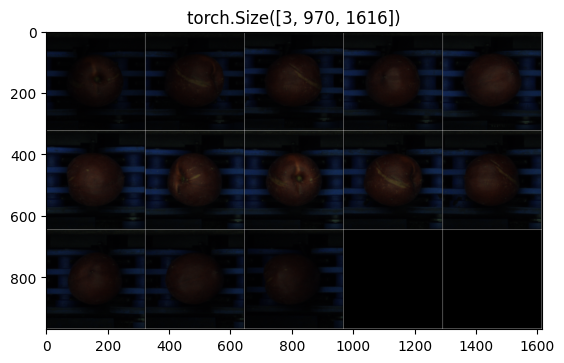

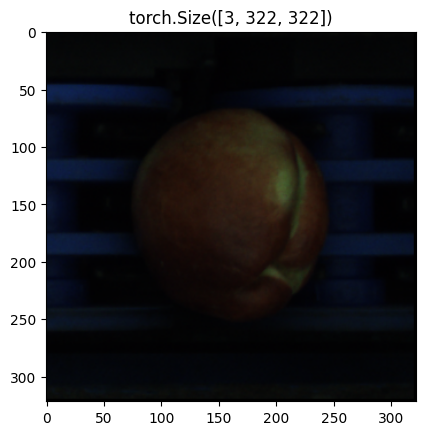

In [4]:
plt.title(example_collage.shape)
plt.imshow(example_collage.permute(1,2,0))
plt.show()

example_img = fruits["Pasul"][0].images[0]
plt.title(example_img.shape)
plt.imshow(example_img.permute(1,2,0))
plt.show()

# Modelling

## Data

In [5]:
max_imgs_per_fruit = max([max([fruit.images.shape[0] for fruit in fruits[rating]]) for rating in quality_ratings])

Different fruits have different numbers of images.  How are we to represent a fruit?  A few options (in order of rising complexity) are:
- Replace the missing images with zeros (black images).  Not implemented.
- <b>Fully classify each image on its own and then take the minimal rating.</b>  This approach is a direct application of the rule that a fruit is judged by its worst POV, and is a priori probably the best implementation.
- Compute an embedding for each image, aggregate, and then classify the aggregated embedding.  This has the benefit of giving the model all possible data when considering a fruit, which can be useful for discovering a priori unknown signs of a given rating (e.g. although we would imagine at first that the only relevant signs are those on the surface of the fruit such as holes or rot, perhaps in fact the shape of the fruit can provide additional information relevant to its rating.  The shape is most easily obtained by considering multiple views of the fruit).

In [6]:
all_fruits = list(itertools.chain.from_iterable(fruits.values()))
# all_fruits = all_fruits[:3]  # DEBUG
train_eval_fruits, test_fruits = sklearn.model_selection.train_test_split(
    all_fruits,
    random_state=SKLEARN_RANDOM_SEED
)
train_fruits, eval_fruits = sklearn.model_selection.train_test_split(
    train_eval_fruits, 
    test_size=0.1,  # Small eval set because insufficient data
    train_size=1-0.1,
    random_state=SKLEARN_RANDOM_SEED+1
)
train_ds = torch.utils.data.TensorDataset(
    torch.stack([torch.nn.functional.pad(fruit.images, (0,0, 0,0, 0,0, 0,max_imgs_per_fruit-fruit.images.shape[0])) for fruit in train_fruits]),
    torch.tensor([fruit.images.shape[0] for fruit in train_fruits]),
    torch.tensor([quality_ratings.index(fruit.quality_rating) for fruit in train_fruits])
)
eval_ds = torch.utils.data.TensorDataset(
    torch.stack([torch.nn.functional.pad(fruit.images, (0,0, 0,0, 0,0, 0,max_imgs_per_fruit-fruit.images.shape[0])) for fruit in eval_fruits]),
    torch.tensor([fruit.images.shape[0] for fruit in eval_fruits]),
    torch.tensor([quality_ratings.index(fruit.quality_rating) for fruit in eval_fruits])
)
test_ds = torch.utils.data.TensorDataset(
    torch.stack([torch.nn.functional.pad(fruit.images, (0,0, 0,0, 0,0, 0,max_imgs_per_fruit-fruit.images.shape[0])) for fruit in test_fruits]),
    torch.tensor([fruit.images.shape[0] for fruit in test_fruits]),
    torch.tensor([quality_ratings.index(fruit.quality_rating) for fruit in test_fruits])
)

# Images are zero-padded on the end up to the max number of images for a given fruit.
# Labels are tuples (unpadded_number_of_fruit_images, class) with 0 <= class <= 3
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = torch.utils.data.DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Some transforms we would like to attain invariance to are:
- Flip (horizontal and vertical)
- Lighting change (lack of normalization)
- Rotation (since a fruit does not change its rating by being rotated)

These may be addressed with the relevant 
image augmentations

# Model

## Network architecture

In [7]:
class ImglayerToFruitlayer(torch.nn.Module):
        # Torchscript decorator for applying layers meant for images to collections of images (apply the layer to each image)
        def __init__(self, imglayer):
            super().__init__()
            self.imglayer = imglayer
            
        def forward(self, *batch_fruit_imgs):
            imgs_per_fruit = batch_fruit_imgs[0].shape[1]
            mixed_fruits_and_imgs = tuple(
                batch_fruit_imgs_tensor.reshape(-1, *batch_fruit_imgs_tensor.shape[2:]) 
                for batch_fruit_imgs_tensor in batch_fruit_imgs
            )
            processed_imgs = self.imglayer(*mixed_fruits_and_imgs)
            return processed_imgs.reshape(-1, imgs_per_fruit, *processed_imgs.shape[1:])

In [12]:
class FruitQualityClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Output shape: batch_size x 256 x 10 x 10
        self.pretrained_feature_extractor = ImglayerToFruitlayer(
            FruitQualityClassifier._get_resnet_feature_extractor(torchvision.models.resnet18(weights="DEFAULT"))
        )
        self.pretrained_feature_extractor_output_shape = 64, 81, 81 # ablate all denseblocks 128, 40, 40  # ablate denseblocks 2,3,4: 256, 20, 20 ablate denseblock4: 512,10,10 full:1024,10,10
        self.trained_feature_extractor = ImglayerToFruitlayer(
            torch.nn.Sequential(
                torchvision.models.densenet121(weights="DEFAULT").features.denseblock1.denselayer1,
                torch.nn.GELU()
            )
        )
        self.trained_feature_extractor_output_shape = 32, 81, 81
        self.classifier_head = ImglayerToFruitlayer(
            torch.nn.Sequential(
                torch.nn.Flatten(start_dim=1),
                torch.nn.Linear(math.prod(self.trained_feature_extractor_output_shape), 1)
            )
        )

    @staticmethod
    def _get_resnet_feature_extractor(pretrained_model):
        pretrained_model.avgpool = torch.nn.Identity()
        pretrained_model.fc = torch.nn.Identity()
        return pretrained_model

    
    def forward(self, batch_fruit_imgs, batch_num_imgs):
        with torch.no_grad():  # Freeze pretrained net weights
            fruit_pretrained_ftrs = self.pretrained_feature_extractor(batch_fruit_imgs)
        fruit_ftrs = self.trained_feature_extractor(fruit_pretrained_ftrs)


        class_distributions_per_image = self.classifier_head(fruit_ftrs)
        # overwrite rating predictions of pad images (implemented by repeating prediction of last nonpad image)
        class_distributions_per_nonpad_image = class_distributions_per_image.gather(  
            index=torch.min(
                torch.arange(class_distributions_per_image.shape[1], device=class_distributions_per_image.device)\
                    .unsqueeze(0).unsqueeze(2).expand_as(class_distributions_per_image),
                batch_num_imgs.unsqueeze(1).unsqueeze(2) - 1  # Identity gather, clipped to last nonpad image
            ),
            dim=1
        )
        worst_img = class_distributions_per_nonpad_image.max(dim=2).indices.min(dim=1).values
        preds_per_fruit = class_distributions_per_nonpad_image[torch.arange(class_distributions_per_nonpad_image.shape[0]), worst_img, :]
        return preds_per_fruit

model = FruitQualityClassifier().to(device)

In [13]:
model.pretrained_feature_extractor.imglayer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# class ResidualConnection(torch.nn.Module):
#     def __init__(self, in_shape, out_shape):
#         super().__init__()
#         self.channel_adapt = torch.nn.Conv2d(in_shape[0], out_shape[0], kernel_size=(1,1))
#         self.height_adapt = torch.nn.Parameter(torch.empty(1, out_shape[1], in_shape[1]))
#         torch.nn.init.xavier_normal_(self.height_adapt)
#         self.width_adapt = torch.nn.Parameter(torch.empty(1, in_shape[2], out_shape[2]))
#         torch.nn.init.xavier_normal_(self.width_adapt)

#     def forward(self, new_img, old_img):
#         return new_img + self.channel_adapt(self.height_adapt @ old_img @ self.width_adapt)

In [15]:
# class FruitQualityClassifier(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.norm0 = ImglayerToFruitlayer(torch.nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#         self.conv0 = ImglayerToFruitlayer(torch.nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False))
#         self.activation0 = torch.nn.GELU()
#         self.pool0 = ImglayerToFruitlayer(torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False, divisor_override=1))
#         self.residual0 = ImglayerToFruitlayer(ResidualConnection((3,322,322), (64,81,81)))

#         self.norm1 = ImglayerToFruitlayer(torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#         self.conv1 = ImglayerToFruitlayer(torch.nn.Conv2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False))
#         self.activation1 = torch.nn.GELU()
#         self.pool1 = ImglayerToFruitlayer(torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False, divisor_override=1))
#         self.residual1 = ImglayerToFruitlayer(ResidualConnection((64,81,81), (32,21,21)))

#         self.norm2 = ImglayerToFruitlayer(torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
#         self.conv2 = ImglayerToFruitlayer(torch.nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False))
#         self.activation2 = torch.nn.GELU()
#         self.residual2 = ImglayerToFruitlayer(ResidualConnection((32,21,21), (32,12,12)))

#         self.trained_feature_extractor_output_shape = 32, 12, 12
#         self.classifier_head = ImglayerToFruitlayer(torch.nn.Sequential(
#             torch.nn.Flatten(start_dim=1),
#             torch.nn.Linear(math.prod(self.trained_feature_extractor_output_shape), 4)
#         ))

    
#     def forward(self, batch_fruit_imgs, batch_num_imgs):        
#         fruit_ftrs0 = self.norm0(batch_fruit_imgs)
#         fruit_ftrs0 = self.conv0(fruit_ftrs0)
#         fruit_ftrs0 = self.activation0(fruit_ftrs0)
#         fruit_ftrs0 = self.pool0(fruit_ftrs0)
#         fruit_ftrs0 = self.residual0(fruit_ftrs0, batch_fruit_imgs)

#         fruit_ftrs1 = self.norm1(fruit_ftrs0)
#         fruit_ftrs1 = self.conv1(fruit_ftrs1)
#         fruit_ftrs1 = self.activation1(fruit_ftrs1)
#         fruit_ftrs1 = self.pool1(fruit_ftrs1)
#         fruit_ftrs1 = self.residual1(fruit_ftrs1, fruit_ftrs0)

#         fruit_ftrs2 = self.norm2(fruit_ftrs1)
#         fruit_ftrs2 = self.conv2(fruit_ftrs2)
#         fruit_ftrs2 = self.activation2(fruit_ftrs2)
#         fruit_ftrs2 = self.residual2(fruit_ftrs2, fruit_ftrs1)
        
#         class_distributions_per_image = self.classifier_head(fruit_ftrs2)
#         # overwrite rating predictions of pad images (implemented by repeating prediction of last nonpad image)
#         class_distributions_per_nonpad_image = class_distributions_per_image.gather(  
#             index=torch.min(
#                 torch.arange(class_distributions_per_image.shape[1], device=class_distributions_per_image.device)\
#                     .unsqueeze(0).unsqueeze(2).expand_as(class_distributions_per_image),
#                 batch_num_imgs.unsqueeze(1).unsqueeze(2) - 1  # Identity gather, clipped to last nonpad image
#             ),
#             dim=1
#         )
#         worst_img = class_distributions_per_nonpad_image.max(dim=2).indices.min(dim=1).values
#         preds_per_fruit = class_distributions_per_nonpad_image[torch.arange(class_distributions_per_nonpad_image.shape[0]), worst_img, :]
#         return preds_per_fruit


# model = FruitQualityClassifier().to(device)

## Training architecture

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

## Train loop

In [17]:
def targets_distribution(targets):
    return torch.nn.functional.sigmoid(targets - torch.arange(len(quality_ratings), dtype=torch.float32).mean())
    # return targets / (len(quality_ratings) - 1)

In [18]:
ratings_normalized = targets_distribution(torch.arange(len(quality_ratings), dtype=torch.float32, device=device)).unsqueeze(0)
def eval_model(model, eval_dl):
    total_correct = 0
    total_samples = 0
    for fruit_imgs, num_imgs, targets in eval_dl:
        fruit_imgs, num_imgs, targets = fruit_imgs.to(device), num_imgs.to(device), targets.to(device)
        fruit_imgs = fruit_imgs/MAX_BYTE if fruit_imgs.dtype==torch.uint8 else fruit_imgs
        total_samples += targets.shape[0]
        preds = model(fruit_imgs, num_imgs).max(dim=1).indices
        total_correct += (targets == preds).sum()
        if total_correct > total_samples:
            raise Exception
    return total_correct / total_samples

In [19]:
transforms = ImglayerToFruitlayer(
    torch.nn.Sequential(
        torchvision.transforms.Normalize(mean=0, std=1),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomRotation(180)
    )
)

In [20]:
# %debug
losses, eval_accuracies = [], []
GRAPH_EVERY = 10
eval_accuracy = 0

for epoch in range(NUM_EPOCHS):
    for fruit_imgs, num_imgs, targets in (pbar := tqdm(train_dl)):
        # fruit_imgs.shape: batch_size x imgs_per_fruit x color_channels x height x width
        fruit_imgs, num_imgs, targets = fruit_imgs.to(device), num_imgs.to(device), targets.to(device)
        fruit_imgs = fruit_imgs/MAX_BYTE if fruit_imgs.dtype==torch.uint8 else fruit_imgs
        fruit_imgs = transforms(fruit_imgs)
        preds = model(fruit_imgs, num_imgs)
        loss = loss_fn(preds, torch.nn.functional.one_hot(targets, num_classes=4).to(torch.float32))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description(f"Train loss: {round(loss.cpu().item(), 3)}")
        losses.append(loss.cpu().item())
    eval_accuracy = eval_model(model, eval_dl)
    print(f"Epoch {epoch} completed with eval accuracy {round(eval_accuracy.cpu().item(), 3)}")
    eval_accuracies.append(eval_accuracy.cpu().item())

    if epoch % GRAPH_EVERY == 0 and epoch != 0:
        plt.plot(losses)
        # plt.title(f"Epoch {epoch}: Train losses")
        plt.show()
        plt.plot(eval_accuracies)
        plt.title(f"Epoch {epoch}: Eval accuracies")
        plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

ValueError: expected 4D input (got 2D input)

In [ ]:
save(model, "densenet_class_cnn_model_weights.pth")

<b>Feature extraction:</b>

A visual inspection of the data suggests that some relevant features for quality classification are:
- The color histogram (rot and discoloration seems to have a distinctive color)
- The average magnitude of the photo gradients (a good fruit should have mostly gradual changes of color)
- The average curvature of curves extracted with a high-pass filter (a good fruit may have spots on it, but they should have smooth edges)

This may be complemented by deep features.  A suggested feature extractor is deformable convolutions, which will help the model attain local affine invariance (a bad sign is still bad even when rotated/rescaled).